# GLRM Showcase

The following notebook is taken from Anqi (the original GLRM author at H2O).  

I want to illustrate several things in this notebook:
- analyzing archetype (Y),
- analyzing coefficients (X),
- advantages of using GLRM to build your model.

## Start H2O cluster

In [1]:
library(h2o)
h2o.init(bind_to_localhost = FALSE, context_path="h2o")


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, apply, as.factor, as.numeric, colnames, colnames<-,
    ifelse, is.character, is.factor, is.numeric, log, log10, log1p,
    log2, round, signif, trunc, ||




H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/Rtmp9b7pOb/h2o_UnknownUser_started_from_r.out
    /tmp/Rtmp9b7pOb/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 398 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.24.0.5 
    H2O cluster version age:    1 month and 30 days  
    H2O cluster name:           H2O_started_from_R_h2o_sng071 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   13.98 GB 
    H2O cluster total cores:    16 
    H2O cluster allowed cores:  16 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoos

## Gait Data

The following dataset contains information from various human subjects walking on a treadmill.  In particular, each subject is attached with sensors at the various joints.  Data from the sensors are collected.

In [2]:
#filename <- "http://s3.amazonaws.com/h2o-public-test-data/smalldata/glrm_test/subject01_walk1.csv"
filename <- "../../data/glrm/subject01_walk1.csv"
gait.hex <- h2o.importFile(path = filename, destination_frame = "gait.hex")
dim(gait.hex)
summary(gait.hex)

  |======================================================================| 100%


[1] 151 124

Warning message in summary.H2OFrame(gait.hex):
"Approximated quantiles computed! If you are interested in exact quantiles, please pass the `exact_quantiles=TRUE` parameter."

 Time             R.ASIS.X        R.ASIS.Y       R.ASIS.Z       
 Min.   :0.0000   Min.   :588.9   Min.   :1043   Min.   :107.8  
 1st Qu.:0.6238   1st Qu.:600.9   1st Qu.:1053   1st Qu.:123.3  
 Median :1.2500   Median :612.4   Median :1066   Median :148.3  
 Mean   :1.2500   Mean   :613.8   Mean   :1066   Mean   :147.3  
 3rd Qu.:1.8738   3rd Qu.:628.1   3rd Qu.:1079   3rd Qu.:172.4  
 Max.   :2.5000   Max.   :641.1   Max.   :1091   Max.   :180.1  
 L.ASIS.X        L.ASIS.Y       L.ASIS.Z          V.Sacral.X     
 Min.   :600.0   Min.   :1029   Min.   :-152.54   Min.   :399.4  
 1st Qu.:611.0   1st Qu.:1041   1st Qu.:-137.53   1st Qu.:408.0  
 Median :618.6   Median :1054   Median :-111.55   Median :418.6  
 Mean   :621.8   Mean   :1054   Mean   :-113.09   Mean   :419.6  
 3rd Qu.:625.9   3rd Qu.:1068   3rd Qu.: -88.24   3rd Qu.:430.0  
 Max.   :661.5   Max.   :1078   Max.   : -80.37   Max.   :451.6  
 V.Sacral.Y     V.Sacral.Z         R.Thigh.Upper.X R.Thigh.Upper.Y
 Min.   :1035   

We will build a GLRM model using quadratic loss and no regularization since the dataset contains only numeric features.  Skip the first column (time) and set k=10.

In [3]:
gait.glrm <- h2o.glrm(training_frame = gait.hex, cols = 2:ncol(gait.hex), k = 10, loss = "Quadratic", 
                      regularization_x = "None", regularization_y = "None", max_iterations = 1000)

  |======================================================================| 100%


The dataset basically contains the spatial information of a user's head, temple, toes, wrists, elbows, biceps, sternum, acromium (shoulder above arm joint), midfoots, heels, rear/upper shank, thigh, ....  What do you think the archetypes will look like?


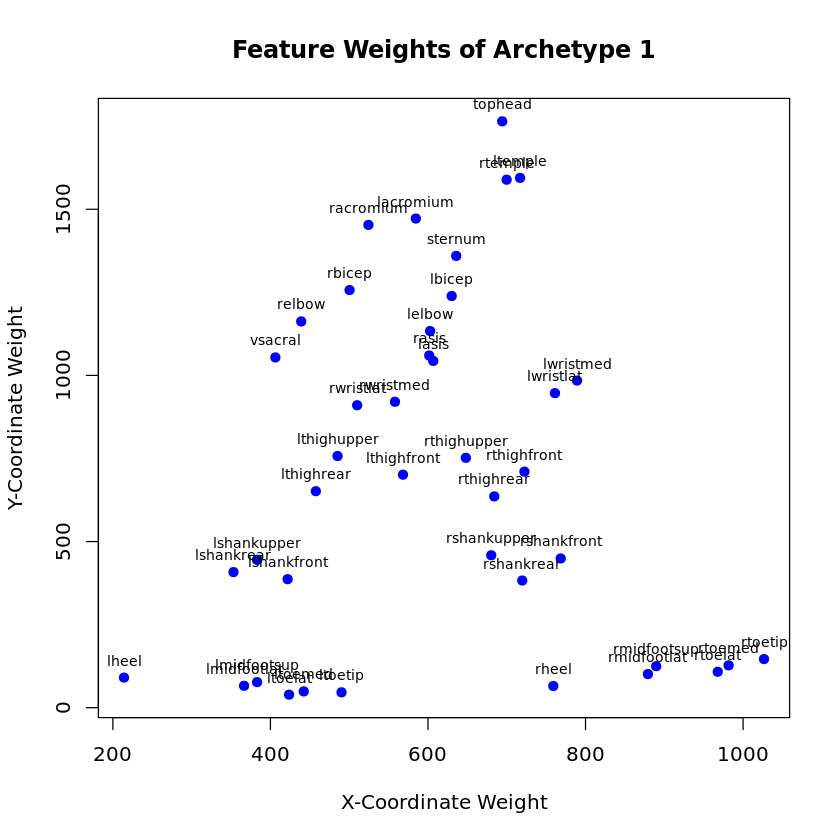

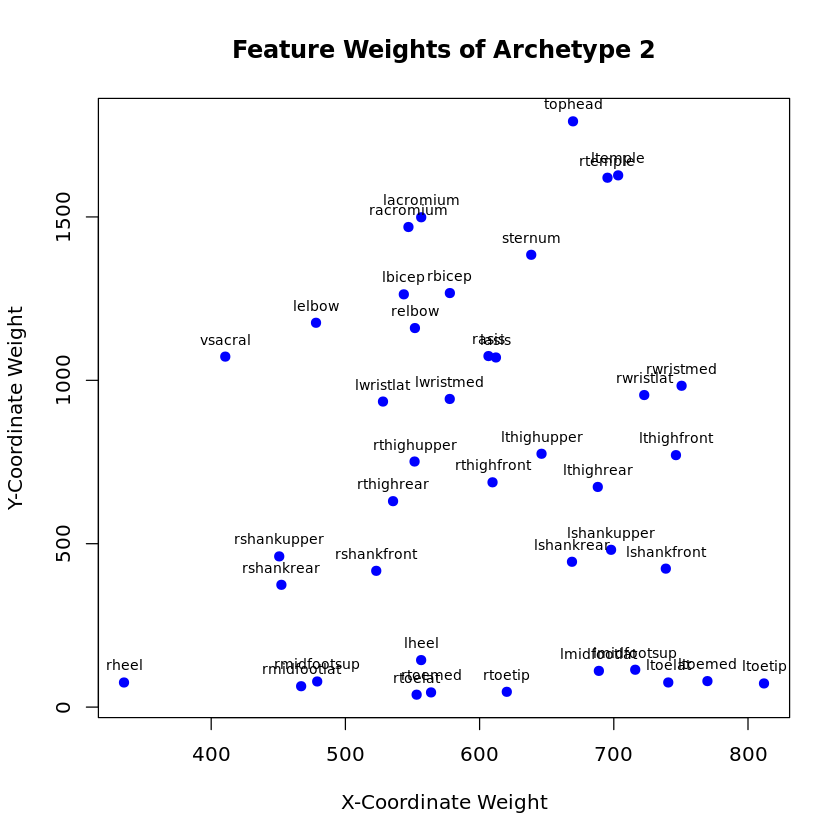

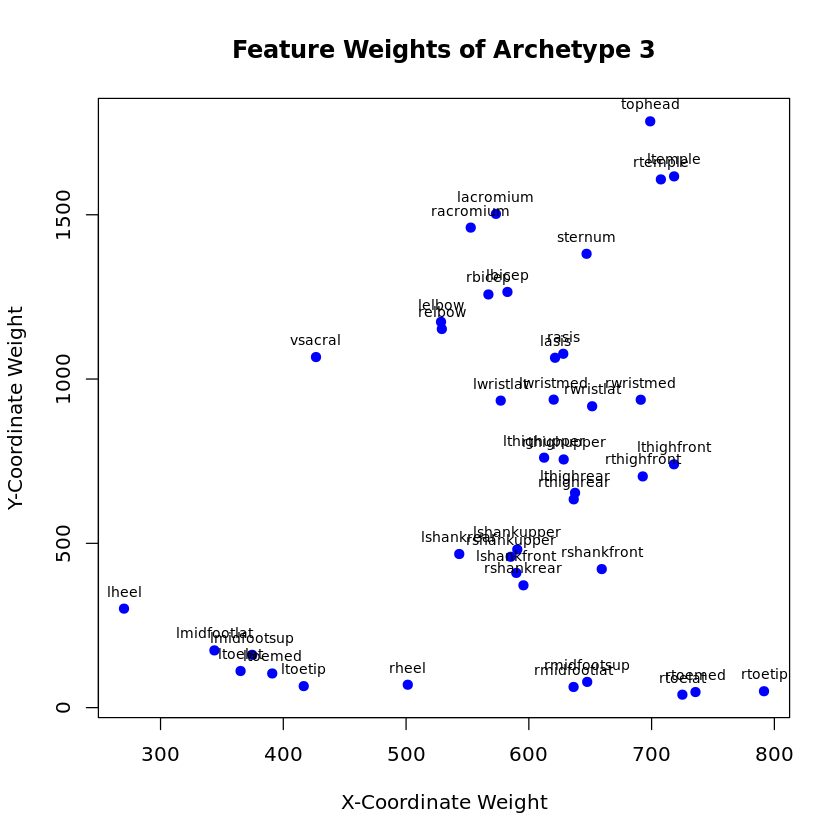

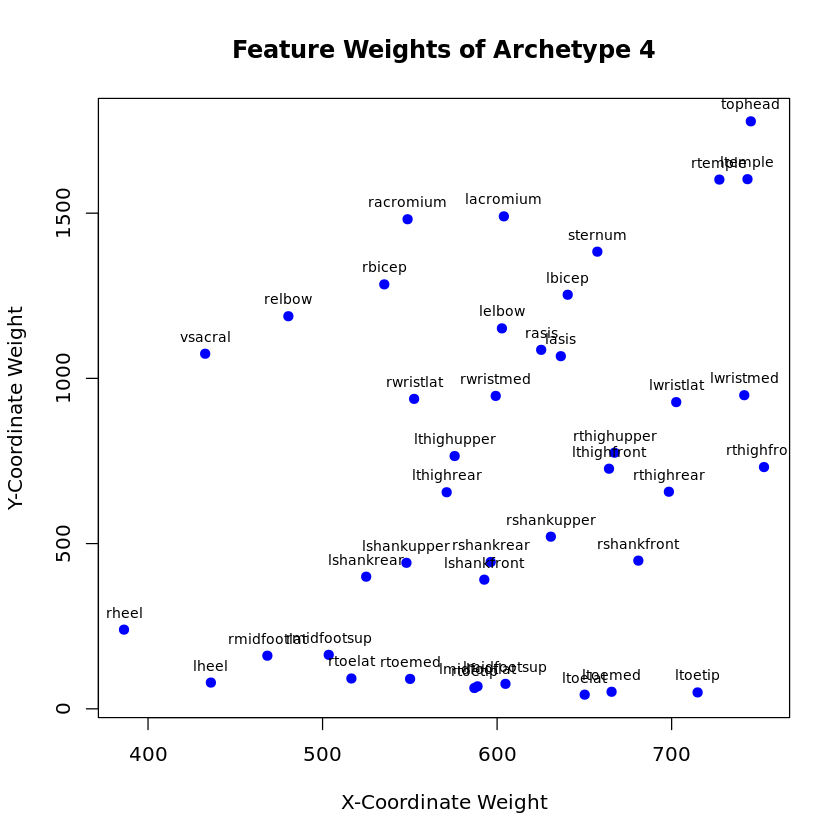

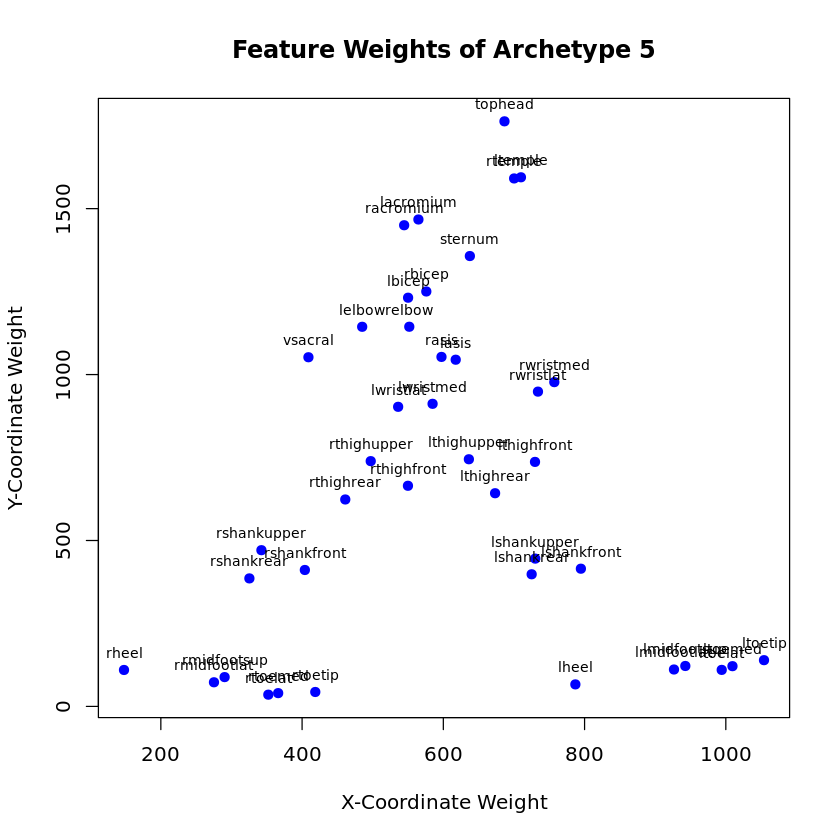

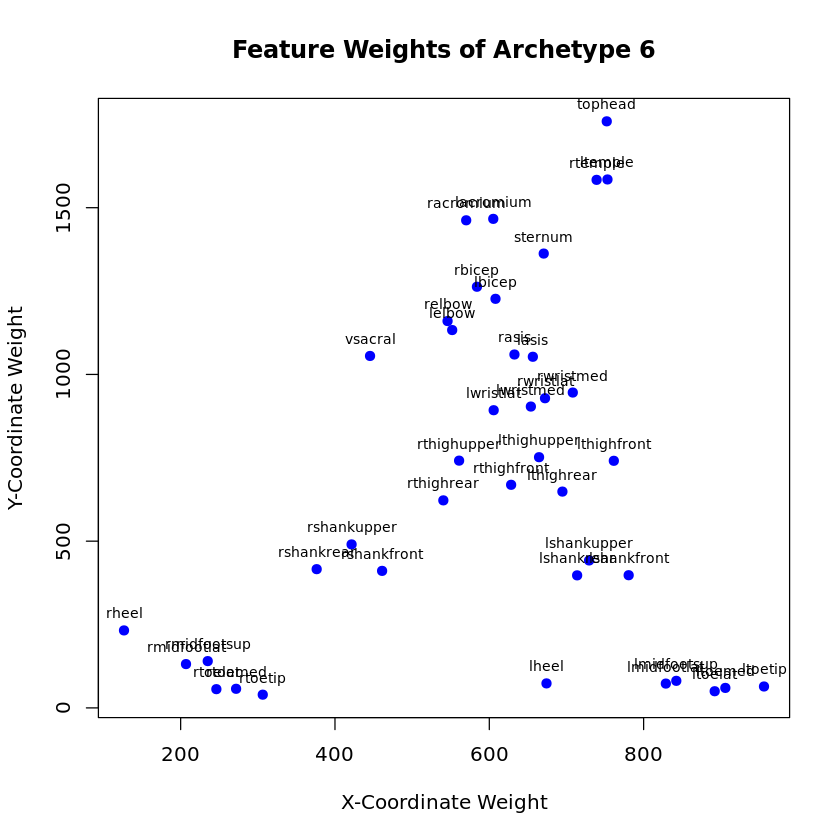

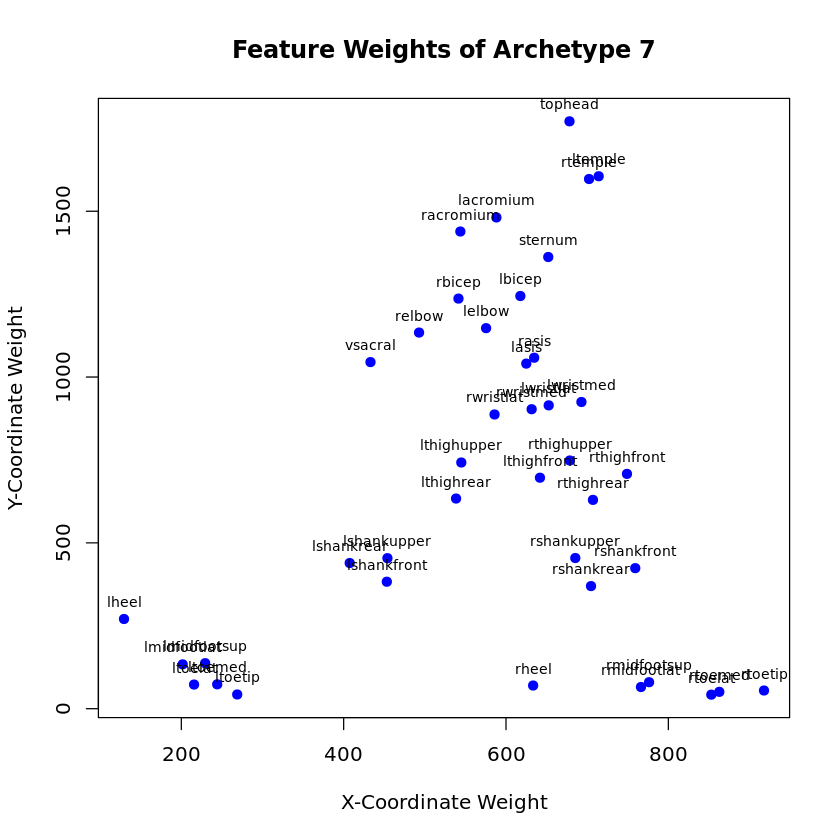

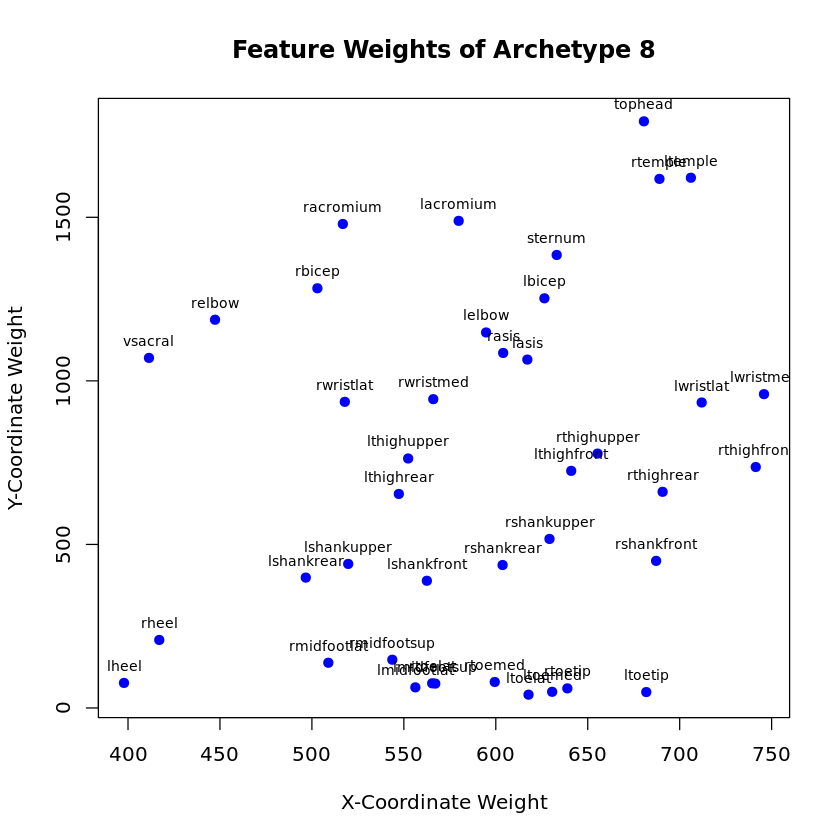

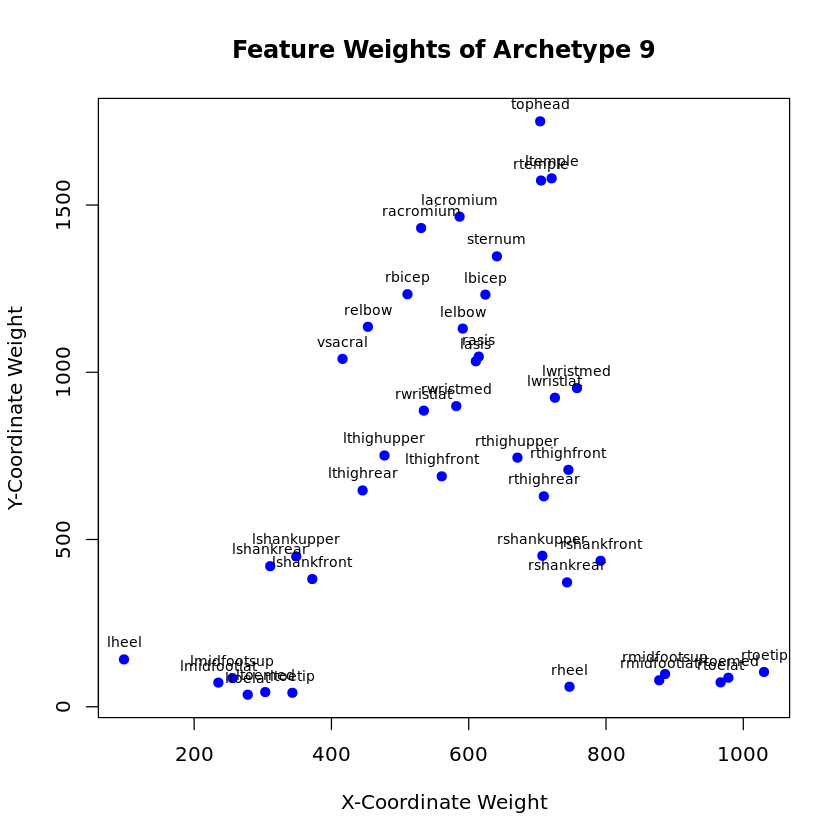

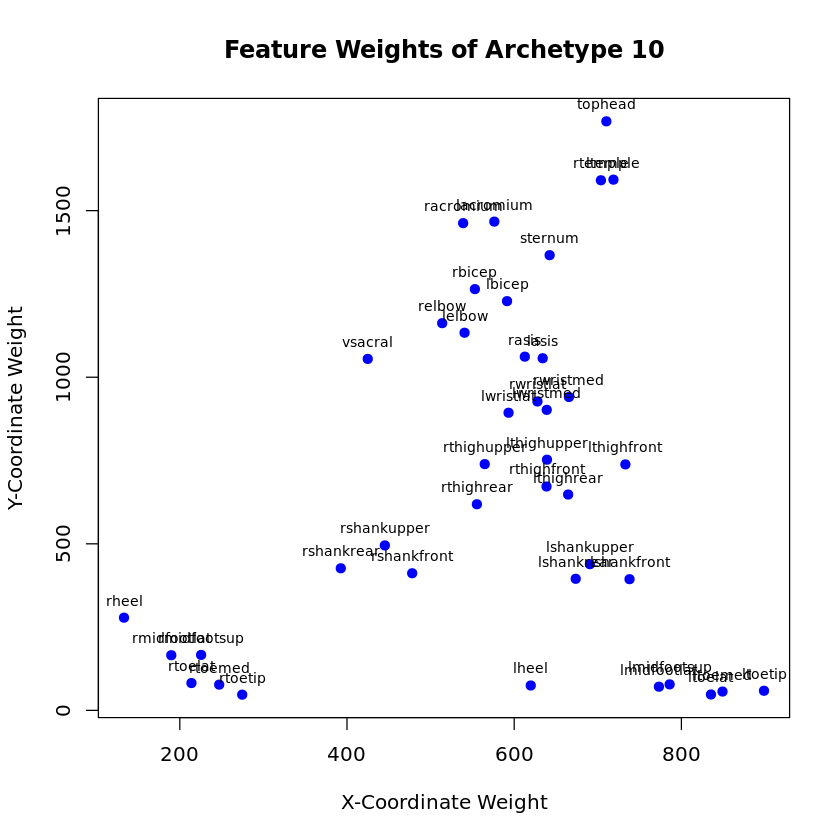

In [4]:
gait.y <- gait.glrm@model$archetypes
gait.y.mat <- as.matrix(gait.y)
x_coords <- seq(1, ncol(gait.y), by = 3)
y_coords <- seq(2, ncol(gait.y), by = 3)
feat_nams <- sapply(colnames(gait.y), function(nam) { substr(nam, 1, nchar(nam)-1) })
feat_nams <- as.character(feat_nams[x_coords])
for(k in 1:10) {
    plot(gait.y.mat[k,x_coords], gait.y.mat[k,y_coords], xlab = "X-Coordinate Weight", ylab = "Y-Coordinate Weight", main = paste("Feature Weights of Archetype", k), col = "blue", pch = 19, lty = "solid")
    text(gait.y.mat[k,x_coords], gait.y.mat[k,y_coords], labels = feat_nams, cex = 0.7, pos = 3)

}

Next, we want to understand if we break our data into A=XY, for a given set of Y, what can we use X for?  What can X show us?  

## ACS Data

In this example, we want to predict whether a firm will repeat an offense or not after a compliance action has been carried out on a firm.  The dataset collected here includes information on each investigation, including zip code (ZCTA) where the firm is located, number of violations found, civil penalities assessed.  The zipcode data by itself is not meaningful.  In fact, it is a categorical data with high cardinality (42000).  If we use one hot encoding to expand the zip code column into 42000 columns, our model will run slowly and probably overfit.  

Instead, we choose to user the American Community Survey (ACS) 5-year estimates of household characteristics dataset to expand our zip code column.  Each row of ACS contains information for a unique zip code, other information like household size, income, education level, number of children, etc.  

In [5]:
#filename <- "http://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/census/ACS_13_5YR_DP02_cleaned.zip"
filename <- "../../data/glrm//ACS_13_5YR_DP02_cleaned.zip"
acs_orig <- h2o.importFile(path = filename, col.types = c("enum", rep("numeric", 149)))

  |======================================================================| 100%


In [6]:
dim(acs_orig)
summary(acs_orig)

[1] 32989   150

Warning message in summary.H2OFrame(acs_orig):
"Approximated quantiles computed! If you are interested in exact quantiles, please pass the `exact_quantiles=TRUE` parameter."

 ZCTA5    total_households  family_households families_w_children_under_18
 01001:1  Min.   :    0.0   Min.   :    0.0   Min.   :    0.00            
 01002:1  1st Qu.:  260.5   1st Qu.:  171.9   1st Qu.:   61.22            
 01003:1  Median : 1042.1   Median :  716.2   Median :  275.51            
 01005:1  Mean   : 3504.5   Mean   : 2326.3   Mean   : 1035.66            
 01007:1  3rd Qu.: 4776.4   3rd Qu.: 3208.8   3rd Qu.: 1331.62            
 01008:1  Max.   :43421.0   Max.   :28649.0   Max.   :15305.00            
                                                                          
 married_families  married_w_children_under_18 male_no_wife      
 Min.   :    0.0   Min.   :    0.00            Min.   :   0.000  
 1st Qu.:  138.6   1st Qu.:   34.06            1st Qu.:   8.168  
 Median :  554.5   Median :  192.98            Median :  44.924  
 Mean   : 1706.8   Mean   :  699.79            Mean   : 164.754  
 3rd Qu.: 2336.8   3rd Qu.:  874.10            3rd Qu.: 196.032  
 Max

In [7]:
acs_zcta_col <- acs_orig$ZCTA5
acs_full <- acs_orig[,-which(colnames(acs_orig) == "ZCTA5")]
dim(acs_full)
summary(acs_full)

[1] 32989   149

Warning message in summary.H2OFrame(acs_full):
"Approximated quantiles computed! If you are interested in exact quantiles, please pass the `exact_quantiles=TRUE` parameter."

 total_households  family_households families_w_children_under_18
 Min.   :    0.0   Min.   :    0.0   Min.   :    0.00            
 1st Qu.:  260.5   1st Qu.:  171.9   1st Qu.:   61.22            
 Median : 1042.1   Median :  716.2   Median :  275.51            
 Mean   : 3504.5   Mean   : 2326.3   Mean   : 1035.66            
 3rd Qu.: 4776.4   3rd Qu.: 3208.8   3rd Qu.: 1331.62            
 Max.   :43421.0   Max.   :28649.0   Max.   :15305.00            
                                                                 
 married_families  married_w_children_under_18 male_no_wife      
 Min.   :    0.0   Min.   :    0.00            Min.   :   0.000  
 1st Qu.:  138.6   1st Qu.:   34.06            1st Qu.:   8.168  
 Median :  554.5   Median :  192.98            Median :  44.924  
 Mean   : 1706.8   Mean   :  699.79            Mean   : 164.754  
 3rd Qu.: 2336.8   3rd Qu.:  874.10            3rd Qu.: 196.032  
 Max.   :19802.0   Max.   :11351.00            Max.   :4083.000  
          

After removing the zip code column, we build a GLRM model out of the ACS data with k=10.

  |======================================================================| 100%


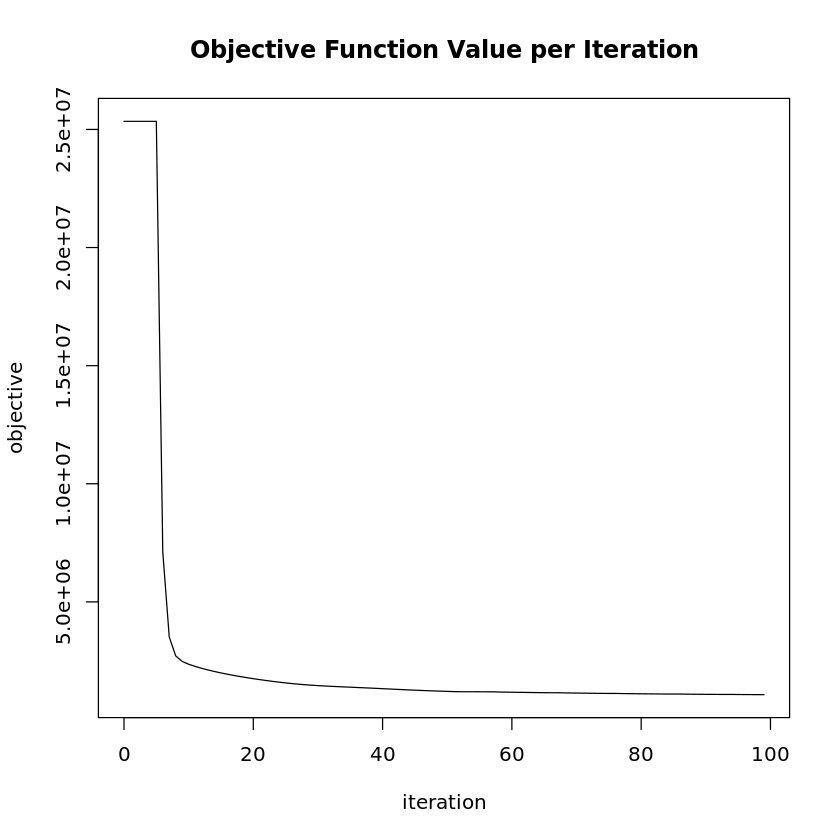

In [8]:
acs_model <- h2o.glrm(training_frame = acs_full, k = 10, transform = "STANDARDIZE", 
                      loss = "Quadratic", regularization_x = "Quadratic", 
                      regularization_y = "L1", max_iterations = 100, gamma_x = 0.25, gamma_y = 0.5)
plot(acs_model)

Each row of X represents the coefficients needed represent a row of ACS dataset using the archetypes in Y.  For cities that are similar, you will expect them to have similar X values.

In [9]:
zcta_arch_x <- h2o.getFrame(acs_model@model$representation_name)
head(zcta_arch_x)

Arch1,Arch2,Arch3,Arch4,Arch5,Arch6,Arch7,Arch8,Arch9,Arch10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.01124218,-0.008391287,0.31831250,0.133985472,-0.06868174,-0.003139341,0.07988233,0.10593975,0.05408210,-0.01646228
0.06545567,0.021485033,0.23456734,-0.151693701,0.29154190,0.336950498,-0.04606971,0.09721989,0.25916941,-0.28827678
0.25768248,0.006534037,0.09097411,0.008924604,0.19975333,0.080307682,-0.05229437,-0.13712724,0.06144000,-0.13598958
0.11936051,-0.005771355,0.16030476,0.074624547,0.01854810,-0.038399782,-0.01264417,0.05720433,-0.01397015,-0.00828788
0.04426318,0.011161840,0.28926550,0.080064668,0.01063676,-0.015736165,0.00155878,0.07290811,0.06960463,-0.02465623
0.14169658,-0.012680510,0.07455393,0.024235330,0.02799393,-0.026490176,-0.01642457,0.10332641,-0.04371553,-0.02948002


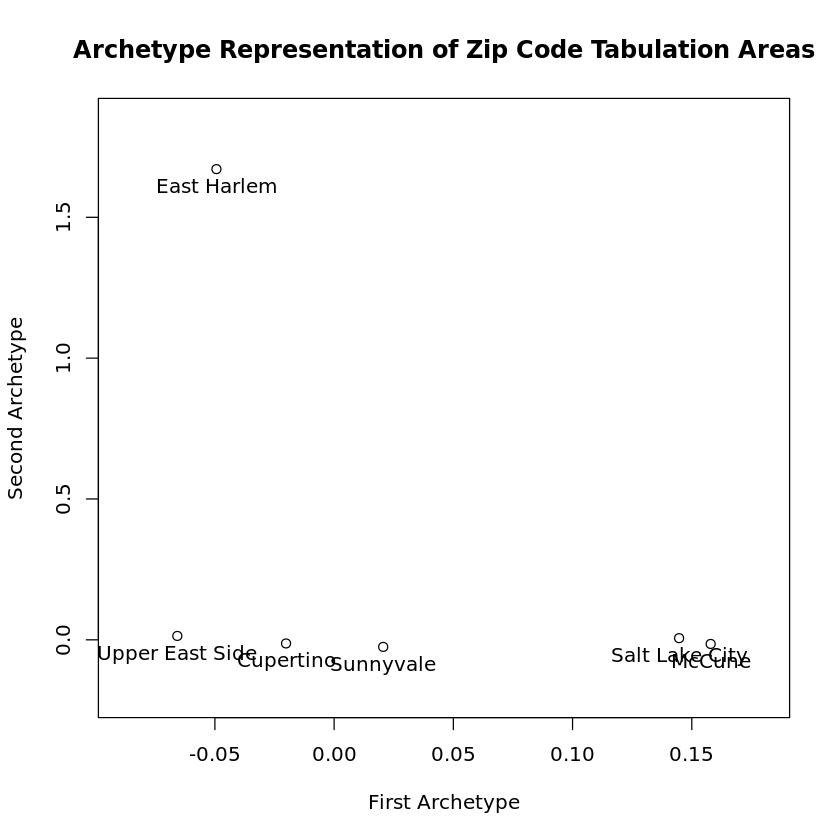

In [10]:
idx <- ((acs_zcta_col == "10065") |   # Manhattan, NY (Upper East Side)
        (acs_zcta_col == "11219") |   # Manhattan, NY (East Harlem)
        (acs_zcta_col == "66753") |   # McCune, KS
        (acs_zcta_col == "84104") |   # Salt Lake City, UT
        (acs_zcta_col == "94086") |   # Sunnyvale, CA
        (acs_zcta_col == "95014"))    # Cupertino, CA

city_arch <- as.data.frame(zcta_arch_x[idx,1:2])
xeps <- (max(city_arch[,1]) - min(city_arch[,1])) / 10
yeps <- (max(city_arch[,2]) - min(city_arch[,2])) / 10
xlims <- c(min(city_arch[,1]) - xeps, max(city_arch[,1]) + xeps)
ylims <- c(min(city_arch[,2]) - yeps, max(city_arch[,2]) + yeps)
plot(city_arch[,1], city_arch[,2], xlim = xlims, ylim = ylims, xlab = "First Archetype", ylab = "Second Archetype", main = "Archetype Representation of Zip Code Tabulation Areas")
text(city_arch[,1], city_arch[,2], labels = c("Upper East Side", "East Harlem", "McCune", "Salt Lake City", "Sunnyvale", "Cupertino"), pos = 1)

Cities like Sunnyvale and Cupertino, they are more similar than with East Harlem.  Note that we are able to cluster coefficients of archetypes of similar cities today, we have no idea what each archetype actually represent.  This is a general problem with machine learning.

## WHD Data

Next, we build a deeplearning model on the WHD dataset to predict repeat and/or willful violators.  For comparison purposes, we will train a model using the original dataset, the original dataset with the zip code column replaced by the compressed GLRM representation (the X matrix) and the data with the zip code column replaced with all the demographic features in the ACS dataset.

In [11]:
#filename <- "http://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/census/whd_zcta_cleaned.zip"
filename <- "../../data/glrm/whd_zcta_cleaned.zip"
whd_zcta <- h2o.importFile(path = filename, col.types = c(rep("enum", 7), rep("numeric", 97)))
split <- h2o.runif(whd_zcta)
train <- whd_zcta[split <= 0.8,]
test <- whd_zcta[split > 0.8,]
myY <- "flsa_repeat_violator"
myX <- setdiff(5:ncol(train), which(colnames(train) == myY))
orig_time <- system.time(dl_orig <- h2o.deeplearning(x = myX, y = myY, training_frame = train, 
                                                     validation_frame = test, distribution = "multinomial",
                                                     epochs = 0.1, hidden = c(50,50,50)))


  |======================================================================| 100%


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping bad and constant columns: [h1a_cmp_assd_amt, h1a_violtn_cnt, flsa_smwap_violtn_cnt, h1a_ee_atp_cnt, flsa_smwap_bw_atp_amt, flsa_smwl_ee_atp_cnt, sraw_bw_atp_amt, sraw_ee_atp_cnt, flsa_smwap_ee_atp_cnt, flsa_smwl_violtn_cnt, flsa_smwmg_bw_atp_amt, osha_bw_atp_amt, osha_ee_atp_cnt, flsa_smwmg_ee_atp_cnt, crew_ee_atp_cnt, sraw_violtn_cnt, crew_bw_atp_amt, flsa_smwl_bw_atp_amt, flsa_smwmg_violtn_cnt, h1a_bw_atp_amt].
"

  |======================================================================| 100%


In [12]:
zcta_arch_x$zcta5_cd <- acs_zcta_col
whd_arch <- h2o.merge(whd_zcta, zcta_arch_x, all.x = TRUE, all.y = FALSE)
whd_arch$zcta5_cd <- NULL
train_mod <- whd_arch[split <= 0.8,]
test_mod  <- whd_arch[split > 0.8,]
myX <- setdiff(5:ncol(train_mod), which(colnames(train_mod) == myY))
mod_time <- system.time(dl_mod <- h2o.deeplearning(x = myX, y = myY, training_frame = train_mod, 
                                                   validation_frame = test_mod, distribution = "multinomial",
                                                   epochs = 0.1, hidden = c(50,50,50)))


Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping bad and constant columns: [h1a_cmp_assd_amt, h1a_violtn_cnt, flsa_smwap_violtn_cnt, h1a_ee_atp_cnt, flsa_smwap_bw_atp_amt, flsa_smwl_ee_atp_cnt, sraw_bw_atp_amt, sraw_ee_atp_cnt, flsa_smwap_ee_atp_cnt, flsa_smwl_violtn_cnt, flsa_smwmg_bw_atp_amt, osha_bw_atp_amt, osha_ee_atp_cnt, flsa_smwmg_ee_atp_cnt, crew_ee_atp_cnt, sraw_violtn_cnt, crew_bw_atp_amt, flsa_smwl_bw_atp_amt, flsa_smwmg_violtn_cnt, h1a_bw_atp_amt].
"

  |======================================================================| 100%


In [13]:
colnames(acs_orig)[1] <- "zcta5_cd"
whd_acs <- h2o.merge(whd_zcta, acs_orig, all.x = TRUE, all.y = FALSE)
train_comb <- whd_acs[split <= 0.8,]
test_comb <- whd_acs[split > 0.8,]
myX <- setdiff(5:ncol(train_comb), which(colnames(train_comb) == myY))
comb_time <- system.time(dl_comb <- h2o.deeplearning(x = myX, y = myY, training_frame = train_comb,
                                                     validation_frame = test_comb, distribution = "multinomial",
                                                     epochs = 0.1, hidden = c(50,50,50)))

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
"Dropping bad and constant columns: [h1a_cmp_assd_amt, h1a_violtn_cnt, flsa_smwap_violtn_cnt, h1a_ee_atp_cnt, flsa_smwap_bw_atp_amt, flsa_smwl_ee_atp_cnt, sraw_bw_atp_amt, sraw_ee_atp_cnt, flsa_smwap_ee_atp_cnt, flsa_smwl_violtn_cnt, flsa_smwmg_bw_atp_amt, osha_bw_atp_amt, osha_ee_atp_cnt, flsa_smwmg_ee_atp_cnt, crew_ee_atp_cnt, sraw_violtn_cnt, crew_bw_atp_amt, flsa_smwl_bw_atp_amt, flsa_smwmg_violtn_cnt, h1a_bw_atp_amt].
"

  |======================================================================| 100%


In [14]:
data.frame(original = c(orig_time[3], h2o.logloss(dl_orig, train = TRUE), h2o.logloss(dl_orig, valid = TRUE)),
              reduced  = c(mod_time[3], h2o.logloss(dl_mod, train = TRUE), h2o.logloss(dl_mod, valid = TRUE)),
           combined = c(comb_time[3], h2o.logloss(dl_comb, train = TRUE), h2o.logloss(dl_comb, valid = TRUE)),
           row.names = c("runtime", "train_logloss", "test_logloss"))

,original,reduced,combined
,<dbl>,<dbl>,<dbl>
runtime,21.3530000,4.6940000,6.8150000
train_logloss,0.2443697,0.2318718,0.2704266
test_logloss,0.2386451,0.2365644,0.2796413


Compare the performance between the three models. We see that the model built on the reduced WHD data set finishes almost 10 times faster than the model using the original data set, and it yields a lower log-loss error. The model with the combined WHD-ACS data set does not improve significantly on this error. We can conclude that our GLRM compressed the ZCTA demographics with little informational loss.

In [15]:
h2o.shutdown(prompt = FALSE)

[1] TRUE